<a href="https://colab.research.google.com/github/shi-b-design/data_management_project/blob/main/Full_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
sns.set_palette('husl')
import warnings
import math
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [ ]:
print("We loaded the amazon dataset.")
path = "/content/drive/MyDrive/Dataset/amazon.csv"
df = pd.read_csv(path)

We loaded the amazon dataset.


In [ ]:
#remove duplicates
df = df.drop_duplicates()

In [ ]:
#standardize col names
df.columns = [
    'product_id', 'product_name', 'category', 'discounted_price', 'actual_price',
    'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id',
    'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link'
]

# Since the user_id row has a bunch of user_ids separated by commas, we will separate them
#then we will make new rows for each user
df['user_id'] = df['user_id'].str.split(',')
df = df.explode('user_id')

#We get rid of whitespace characters
df['user_id'] = df['user_id'].str.strip()

In [ ]:
#we can use strip to get rid of the Indian rupee sign and also the % sign.
df["discounted_price"] = df["discounted_price"].str.lstrip("₹")
df["actual_price"] = df["actual_price"].str.lstrip("₹")
df["discount_percentage"] = df["discount_percentage"].str.rstrip("%")

#also replace commas in discounted price and rating_count
df["discounted_price"] = df["discounted_price"].str.replace('[,]','', regex=True)
df["actual_price"] = df["actual_price"].str.replace('[,]','', regex=True)
df["rating_count"] = df["rating_count"].str.replace('[,]', '', regex=True)

#then we can also convert these to their proper numeric form
df["discounted_price"] = df["discounted_price"].astype(float)
df["actual_price"] = df["actual_price"].astype(float)
df["discount_percentage"] = df["discount_percentage"].astype(float)

#We need rating to be numeric as we might need to use this for our recommendation system perhaps later
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

In [ ]:
#we check for missing values
#missingValues = df.isnull().sum()
df.isnull().sum() #we can see that ther eare two null values in rating_count
# Display dataframe and missing value
#df.head(), missingValues

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [ ]:
#replace null/missing values with 0
df["rating_count"].fillna('0', inplace=True)
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [ ]:
df["category"] = df["category"].str.split("|").str[0] #this is to simplify categories, since there are so many categories

In [ ]:
# Make user matrix
userMatrix = df.pivot_table(index='user_id', columns='product_id', values='rating')

# Fill null values with 0
#userMatrix = userMatrix.fillna(0)
userSimilarity = cosine_similarity(userMatrix.fillna(0))

# Make into dataframe
userDF = pd.DataFrame(userSimilarity, index=userMatrix.index, columns=userMatrix.index)

# We have a user id example here
user_id = 'AG3D6O4STAQKAY2UVGEUV46KN35Q'
similar_users = userDF[user_id].sort_values(ascending=False) #this is to ensure that other user_ids with highest similarity are brought to the top when displaying

# Drop user
similar_users.drop(index = user_id, inplace=True)

print("Similar Users: ")
print(similar_users)

#------------------------------------------------------------------------------------
def get_recommendations(user_id):

  # This recommends products to the selected user_id based on similar users
  user_products = df[df['user_id'] == user_id]['product_id'].unique()
  recommended_products = list(user_products) #this is to make sure that the recommended products include what the user already bought. Relevant items will be our true positives for the score calculation.

  #this function will add whatever items that similar users bought to the recommended_products list.
  for similar_user, similarity in similar_users.items():
    if similarity == 1.0:  #Only compare users with the highest 100% similarity
      products = df[df['user_id'] == similar_user]['product_id']
      for product in products:
          if product not in user_products:
              recommended_products.append(product)
      if len(recommended_products) >= 20: #we don't want to show too many products or only show the top 7-10 maybe.
          break

  return recommended_products

#we calculate recall, precision, and f1 all in one go
def calculateScores(relevant_items, recommended_items):


    #found some inspiration from Geeksforgeeks
    true_positives = len(list(set(relevant_items) & set(recommended_items)))
    false_positives = len(set(recommended_items) - set(relevant_items))
    false_negatives = len(set(relevant_items) - set(recommended_items))

    # Calculate precision, recall, and F1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Precision Score:", precision)
    print("Recall Score:", recall)
    print("F1 Score:", f1)


#relevant items is what the user actually bought or reviewed
relevantItems= ['B07JW9H4J1', 'B07JW1Y6XV', 'B07JH1C41D', 'B07JGDB5M1', 'B07JH1CBGW', 'B07JW9H4J1', 'B07JW9H4J1']
recommendations = get_recommendations(user_id)
calculateScores(relevantItems, recommendations)




Similar Users: 
user_id
AENGU523SXMOS7JPDTW52PNNVWGQ    1.0
AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q    1.0
AGYHHIERNXKA6P5T7CZLXKVPT7IQ    1.0
AEQJHCVTNINBS4FKTBGQRQTGTE5Q    1.0
AHMY5CWJMMK5BJRBBSNLYT3ONILA    1.0
                               ... 
AFEE2XTFVQFP4MAL23BITAYVUEDQ    0.0
AFEE2S2P4LI6QSXWSLRVGRLHYIGQ    0.0
AFEDVL6QIKT4RDYRHGMUZAU2JSQQ    0.0
AFECO24WYFOU2KL7C3DMHTEHRU7Q    0.0
AHZZXJWETMZR7SH7C22KVUT7VHAA    0.0
Name: AG3D6O4STAQKAY2UVGEUV46KN35Q, Length: 9041, dtype: float64
Precision Score: 0.8333333333333334
Recall Score: 1.0
F1 Score: 0.9090909090909091


Text(0.5, 1.0, 'Stats of Amazon Dataset')

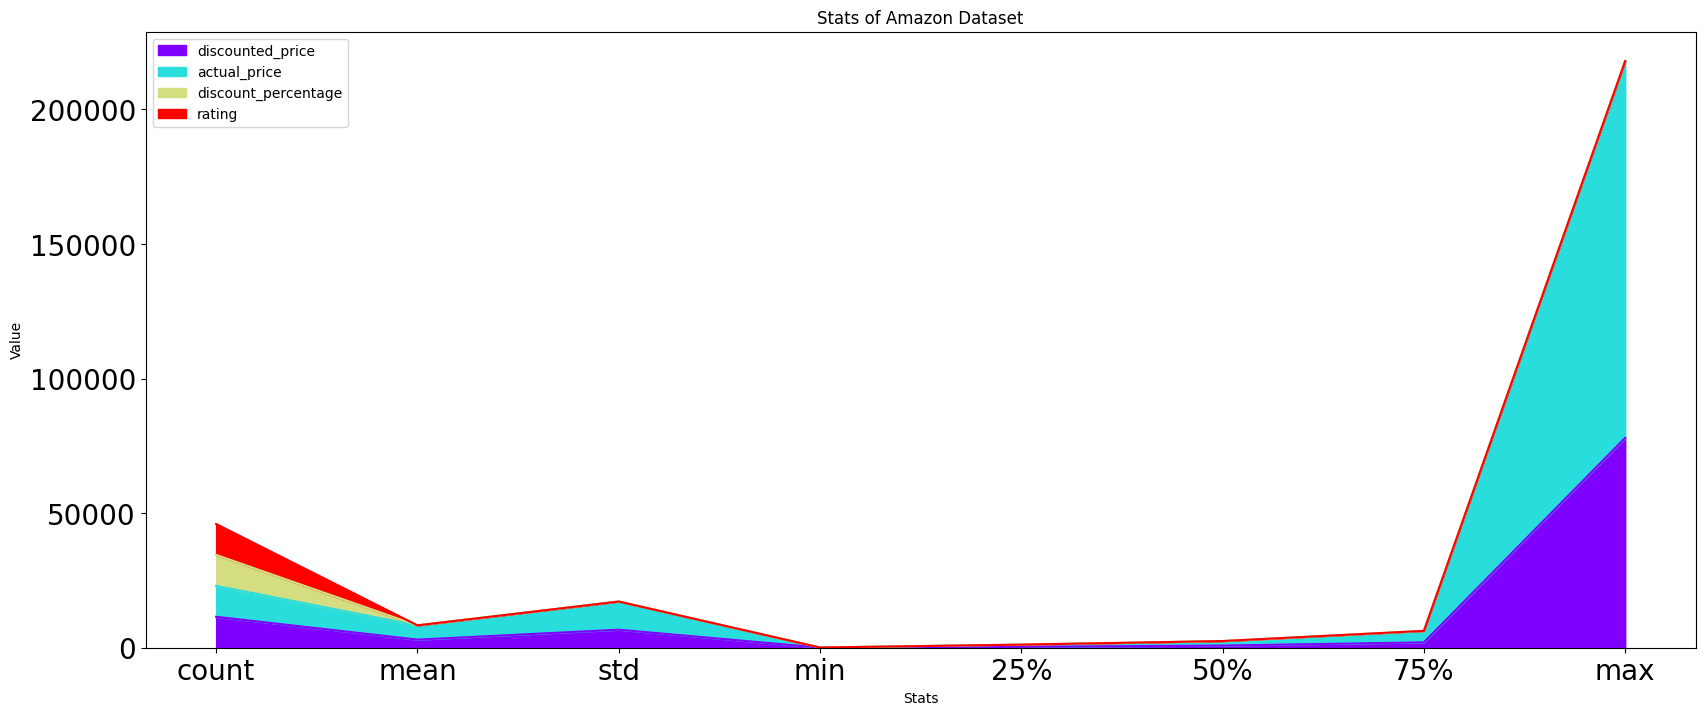

In [ ]:
df.describe().plot(kind="area",fontsize=20,figsize=(20,8),table=False,colormap="rainbow")
plt.xlabel("Stats")
plt.ylabel('Value')
plt.title("Stats of Amazon Dataset")
#this is to show the fluctuation or differences between all item prices. The mean,std, and minimum are all below 50k indian rupees while the max is around 200k rupees

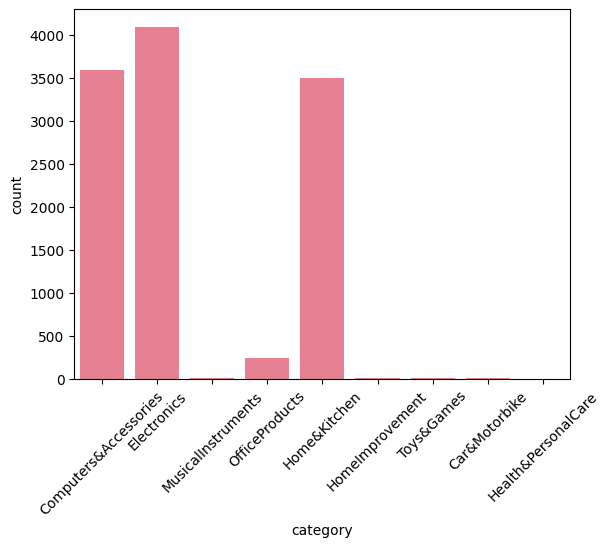

In [ ]:
# Assuming 'df' is your DataFrame
sns.countplot(x="category", data=df)  # Pass 'category' as the 'x' argument
plt.xticks(rotation=45)
plt.show()
#while the graph might look messed up, electronic items have the highest count here